# This dataset contains 9 different seafood types, with using Inception model to classify the images.

https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset/data
https://www.kaggle.com/code/databeru/fish-classifier-grad-cam-viz-acc-99-89


## 1. Start with import libraries

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [2]:
image_dir = Path('/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

In [3]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

,Filepath,Label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Black Sea Sprat
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Shrimp
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream


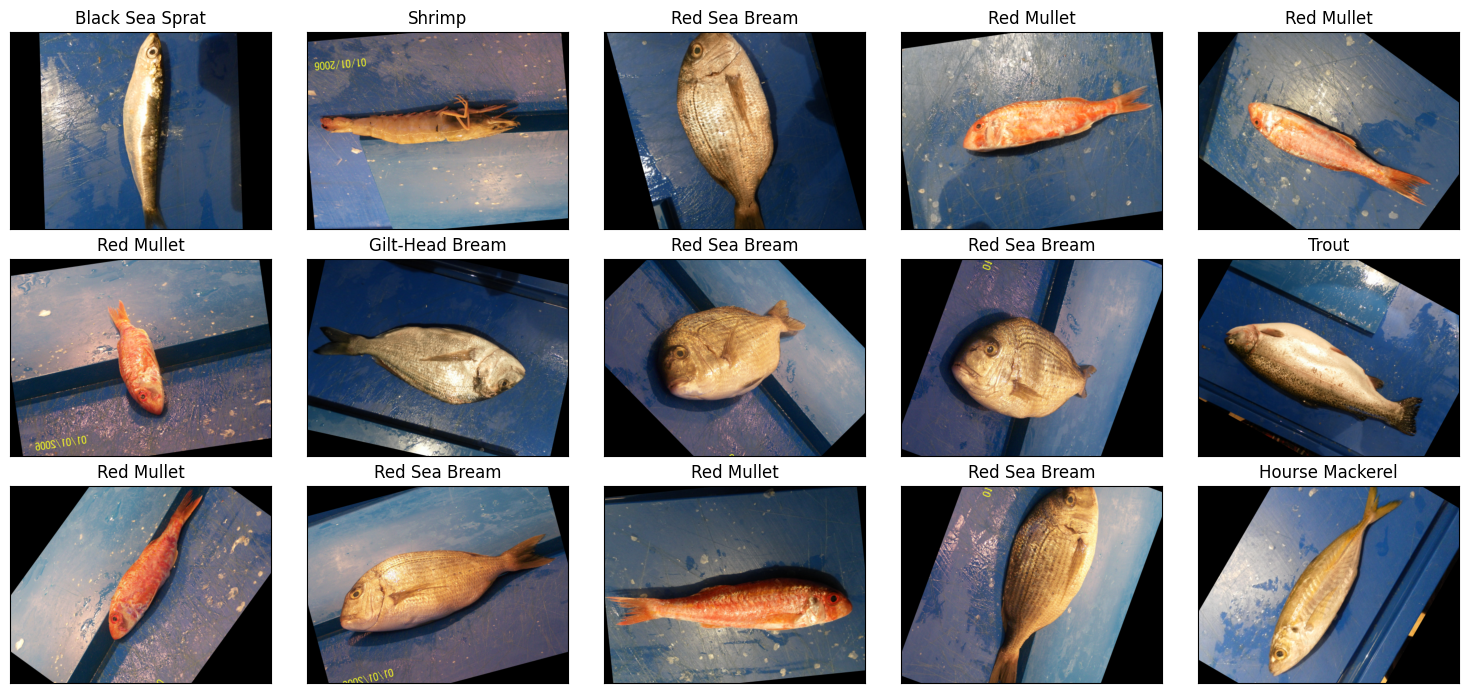

In [4]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [5]:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [6]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [7]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6480 validated image filenames belonging to 9 classes.
Found 1620 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [8]:
# Load the pretained model
pretrained_model = InceptionV3(weights='imagenet', include_top=False)

pretrained_model.trainable = False

## 2. Train Data

In [9]:
inputs = pretrained_model.input

# Apply global pooling to convert 3D output to 1D
x = tf.keras.layers.GlobalAveragePooling2D()(pretrained_model.output)

# Add dense layers after global pooling
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Output layer with 9 units (for 9 classes)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725999276.922825     256 service.cc:145] XLA service 0x7d8474002990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725999276.922868     256 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725999276.922874     256 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/203 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.0391 - loss: 2.4983       

I0000 00:00:1725999285.797194     256 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


203/203 ━━━━━━━━━━━━━━━━━━━━ 127s 534ms/step - accuracy: 0.7882 - loss: 0.6205 - val_accuracy: 0.9580 - val_loss: 0.1185
Epoch 2/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 86s 414ms/step - accuracy: 0.9837 - loss: 0.0552 - val_accuracy: 0.9667 - val_loss: 0.0867
Epoch 3/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 86s 410ms/step - accuracy: 0.9814 - loss: 0.0567 - val_accuracy: 0.9901 - val_loss: 0.0267
Epoch 4/5
203/203 ━━━━━━━━━━━━━━━━━━━━ 86s 412ms/step - accuracy: 0.9803 - loss: 0.0501 - val_accuracy: 0.9889 - val_loss: 0.0297


## 3. Results

In [10]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.02092
Test Accuracy: 99.22%


In [12]:
model.save('large_fish_model_inceptionV3.h5')